# Overfitting & Cross Validation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import numpy as np
import seaborn as sns

import plotly.graph_objects as go
from plotly.io import renderers
renderers.default = 'png'
from plotly.subplots import make_subplots

from utils.design import plotly_main_layout, plotly_main_subplot_layout

___
### Overfitting

In [2]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris['species'] == 'versicolor'] = 1
labels[iris['species'] == 'virginica'] = 2

In [3]:
propTraining = 0.8
nTraining = int(len(labels)*propTraining)

traintestBool = np.zeros(len(labels), dtype=bool)

items2use4train = np.random.choice(range(len(labels)), nTraining, replace=False)
traintestBool[items2use4train] = True

In [4]:
ANNiris = nn.Sequential(
    nn.Linear(4,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,3),
)

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.01)

numepochs = 1000
losses = torch.zeros(numepochs)
ongoingAcc = []

for epochi in range(numepochs):

    yHat = ANNiris(data[traintestBool,:])

    ongoingAcc.append(
        100*torch.mean(
        (torch.argmax(yHat,axis=1) == labels[traintestBool]).float()
        )
    )

    loss = lossfun(yHat, labels[traintestBool])
    losses[epochi] = loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

predictions = ANNiris(data[traintestBool,:])
trainAcc = 100*torch.mean((torch.argmax(yHat,axis=1) == labels[traintestBool]).float())

predictions = ANNiris(data[~traintestBool,:])
testAcc = 100*torch.mean((torch.argmax(yHat,axis=1) == labels[traintestBool]).float())

print(f'Train Accuracy = {trainAcc:.2f}%')
print(f'Test Accuracy = {testAcc:.2f}%')

Train Accuracy = 95.83%
Test Accuracy = 95.83%


___
### Cross-Validation

In [8]:
fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(fakedata, fakelabels, test_size=.2)

# print out the sizes
print('Training data size: ' + str(train_data.shape))
print('Test data size: ' + str(test_data.shape))
print(' ')

Training data size: (8, 4)
Test data size: (2, 4)
 


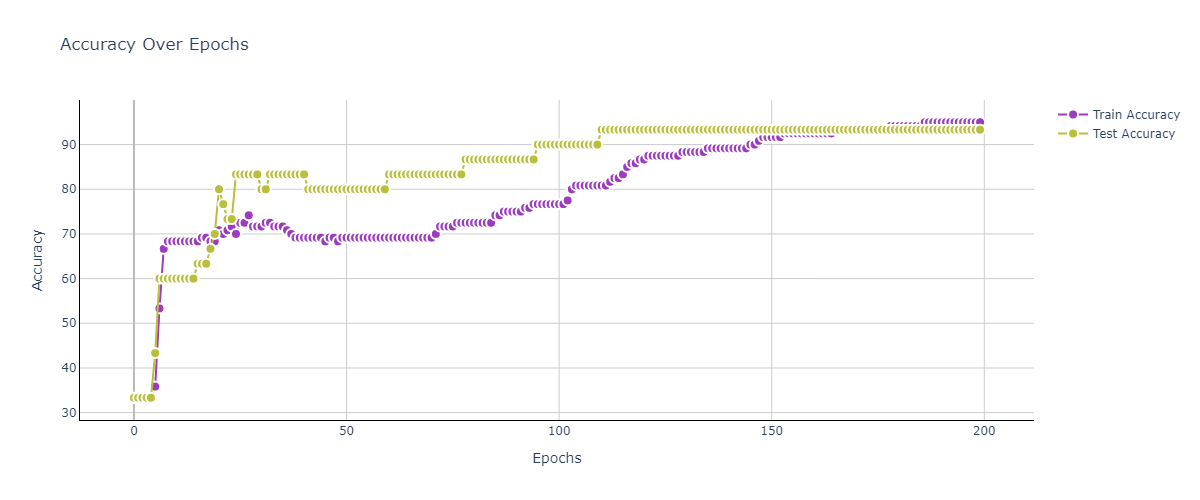

In [90]:
def createANewModel():
    # model architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),   
        nn.ReLU(),         
        nn.Linear(64,64),  
        nn.ReLU(),         
        nn.Linear(64,3),   
    )

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

    return ANNiris, lossfun, optimizer


def trainTheModel(trainProp):

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

    X_train,X_test, y_train,y_test = train_test_split(data,labels, train_size=trainProp)
    for epochi in range(numepochs):

        # forward pass and loss
        yHat = ANNiris(X_train)
        loss = lossfun(yHat,y_train)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute training accuracy
        trainAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y_train).float()).item() )

        # test accuracy
        predlabels = torch.argmax( ANNiris(X_test),axis=1 )
        testAcc.append( 100*torch.mean((predlabels == y_test).float()).item() )

    # function output
    return trainAcc, testAcc

numepochs = 200
ANNiris,lossfun,optimizer = createANewModel()
trainAcc,testAcc = trainTheModel(.8)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAcc, name='Train Accuracy',
    marker=dict(color='#9c3bbf', size=10, line=dict(color='white', width=2)), mode='markers+lines'
))
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAcc, name='Test Accuracy',
    marker=dict(color='#b9bf3b', size=10, line=dict(color='white', width=2)), mode='markers+lines'
))
plotly_main_layout(fig, title='Accuracy Over Epochs', x='Epochs', y='Accuracy', width=1200, height=500)

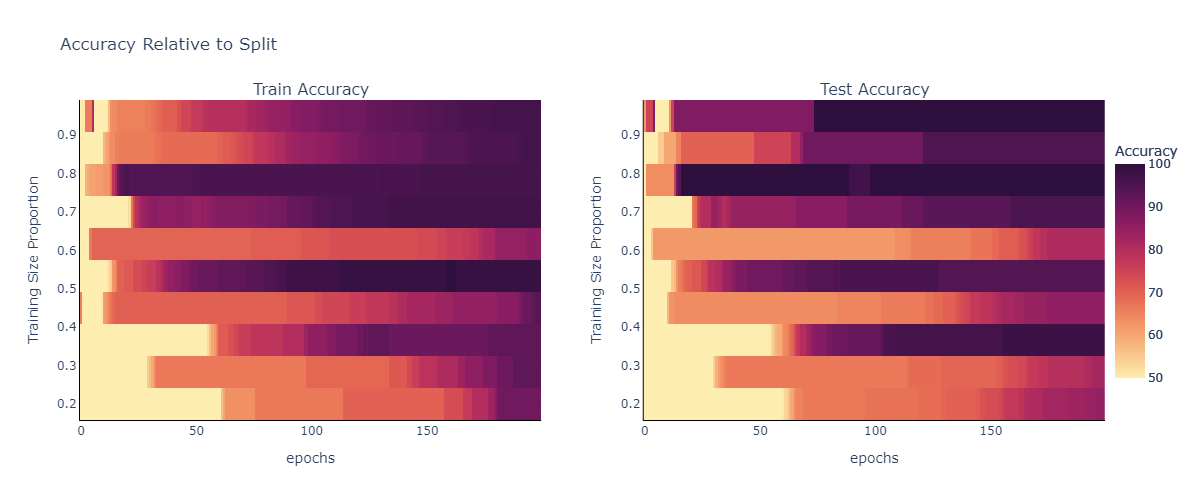

In [48]:
trainSetSizes = np.linspace(.2,.95,10)

allTrainAcc = np.zeros((len(trainSetSizes),numepochs))
allTestAcc = np.zeros((len(trainSetSizes),numepochs))

for i in range(len(trainSetSizes)):

    # create a model
    ANNiris,lossfun,optimizer = createANewModel()

    # train the model
    trainAcc,testAcc = trainTheModel(trainSetSizes[i])

    # store the results
    allTrainAcc[i,:] = trainAcc
    allTestAcc[i,:] = testAcc
        
fig = make_subplots(rows=1, cols=2, subplot_titles=['Train Accuracy', 'Test Accuracy'])
fig.add_trace(go.Heatmap(
    z=allTrainAcc, x=list(range(numepochs)), y=trainSetSizes, 
    colorbar=dict(title='Accuracy', len=0.8, x=1), colorscale='matter', zmin=50, zmax=100,
), row=1, col=1)
fig.add_trace(go.Heatmap(
    z=allTestAcc, x=list(range(numepochs)), y=trainSetSizes, zmin=50, zmax=100,
    colorscale='matter', showscale=True, colorbar=dict(title='Accuracy', len=0.8, x=1)
), row=1, col=2)
plotly_main_subplot_layout(fig, title='Accuracy Relative to Split', x='epochs', y='Training Size Proportion', width=1200)

___
### Data Loader & Batches

In [50]:
iris = sns.load_dataset('iris')
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris['species'] == 'versicolor'] = 1
labels[iris['species'] == 'virginica'] = 2

In [62]:
# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.8)

# PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# DataLoader objects
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


In [92]:
def trainMode():
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        for X, y in train_loader:

            yHat = ANNiris(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(100*torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
        
        trainAcc.append(np.mean(batchAcc))

        X, y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

    return trainAcc, testAcc


numepochs = 300
ANNiris, lossfun, optimizer = createANewModel()
trainAcc, testAcc = trainMode()

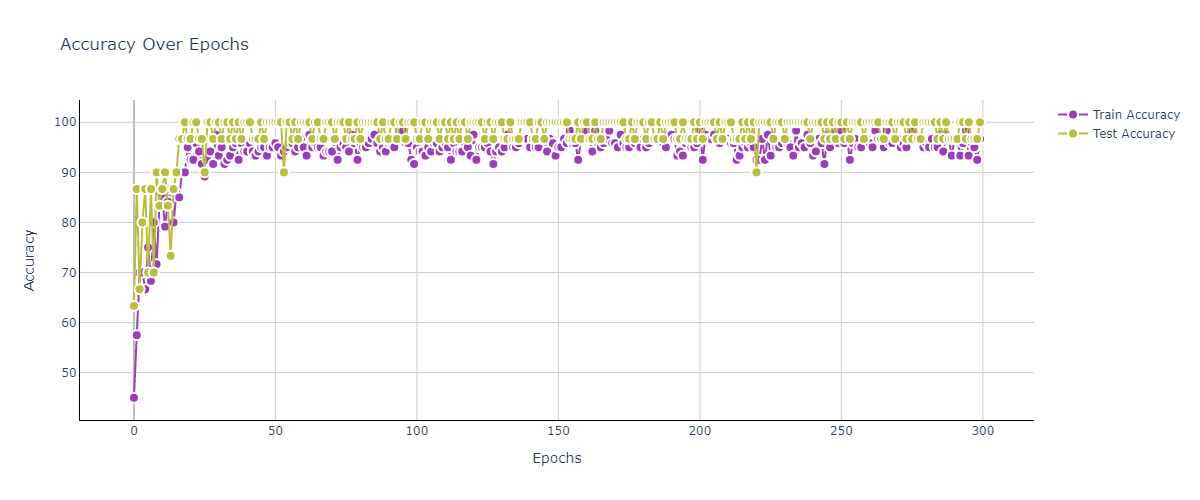

In [93]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAcc, name='Train Accuracy',
    marker=dict(color='#9c3bbf', size=10, line=dict(color='white', width=2)), mode='markers+lines'
))
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAcc, name='Test Accuracy',
    marker=dict(color='#b9bf3b', size=10, line=dict(color='white', width=2)), mode='markers+lines'
))
plotly_main_layout(fig, title='Accuracy Over Epochs', x='Epochs', y='Accuracy', width=1200, height=500)

___
### Train, Test & DevSet

In [105]:
# Partitions
partitions = [0.8, 0.1, 0.1]
train_size_dev_test = partitions[1] / np.sum(partitions[1:])

# Train test split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=partitions[0])
devset_data, test_data, devset_labels, test_labels = train_test_split(test_data, test_labels, train_size=train_size_dev_test)

# PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
devset_data = TensorDataset(devset_data, devset_labels)
test_data = TensorDataset(test_data, test_labels)

# DataLoader objects
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
devset_loader = DataLoader(devset_data, batch_size=devset_data.tensors[0].shape[0])
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

for X, y in train_loader:
    print(X.shape, y.shape)

print()
for X, y in test_loader:
    print(X.shape, y.shape)

print()
for X, y in devset_loader:
    print(X.shape, y.shape)

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])

torch.Size([15, 4]) torch.Size([15])

torch.Size([15, 4]) torch.Size([15])
